# Part II - Ford GoBike Data Anlysis
## by Dane

## Investigation Overview

The overall goal of the analysis was to explore the differences & patterns in rides between the various attributes of the riders such as gender, year of birth, user type.

This presentation will explore:
- Basic information/analysis of the ridership from the dataset.
- Insights into Subscibers vs Customes ridership in terms of when they start their ride (hour of day, day of week) and differences in the duration of their ride.

## Dataset Overview

The data explored is the Ford GoBike data from San Francisco, California from February 1st to 28th, 2019.  The data contains the following information about the riders:

- Memember information: gender, birth year, Subscriber or Customer (one time user).
- Ride information: duration, start station, end station, start and end times.
- Station information: station name, longitutde, latitude.

This analysis will focus on the difference in riding styles between Subscribers and Customers user types of the data set.  Subscribers are riders who pay a monthly fee to rent the bikes and Customers do one time payment to ride.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# import data wrangling functions
from gobike_data_wrangling import gobike_data

Load data set into a DataFrame and drop any gender, birth year, and user type are Null/NaN for the analysis.

In [19]:
# load in the dataset into a pandas dataframe
bikes, stations = gobike_data()

# Set up some default values
default_color = sb.color_palette()[0]

# Remove columns with null values in gender, birth year, and user_type year since this will focus on member analysis
bikes.dropna(subset = ['member_gender', 'member_birth_year', 'user_type'], inplace = True)

## Ridership Breakdown

Let's take a look at some basics stats of the riders in the dataset.  The following breaks down the riders in terms of gender, birth year, and user type.

In [20]:
gender_factor = bikes.member_gender.count()
gender_count = bikes.member_gender.value_counts()
gender_count = gender_count / gender_factor * 100

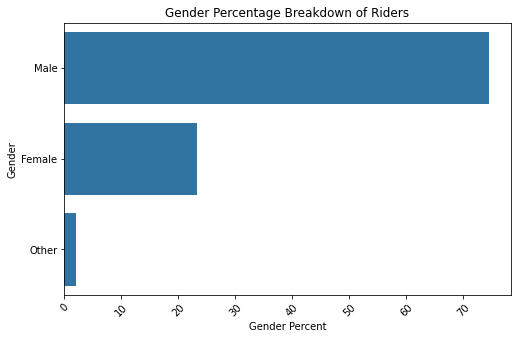

In [21]:
plt.figure(figsize = [10,8])
sb.barplot(x = gender_count.values, y = gender_count.index, color = default_color)
plt.xlabel('Gender Percent')
plt.xticks(rotation = 45)
plt.ylabel('Gender')
plt.title('Gender Percentage Breakdown of Riders');

In [30]:
bin_years = np.arange(1870, bikes.member_birth_year.max()+5, 10)
xticks = np.arange(1870, bikes.member_birth_year.max()+5, 10)
xlabels = []
for i in xticks:
    xlabels.append(str(i) + '-' + str(i+9))
yticks = 10 ** np.arange(0, 6, 1)

array([     1,     10,    100,   1000,  10000, 100000])

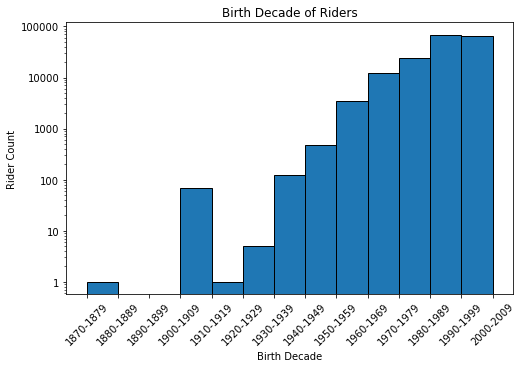

In [44]:
plt.figure(figsize = [10,8])
plt.hist(data = bikes, x = 'member_birth_year', bins = bin_years, edgecolor = 'black')
plt.yscale('log')
plt.xticks(ticks = xticks, labels = xlabels)
plt.xticks(rotation = 45)
plt.yticks(ticks = yticks, labels = yticks)
plt.ylabel('Rider Count')
plt.xlabel('Birth Decade')
plt.title('Birth Decade of Riders');

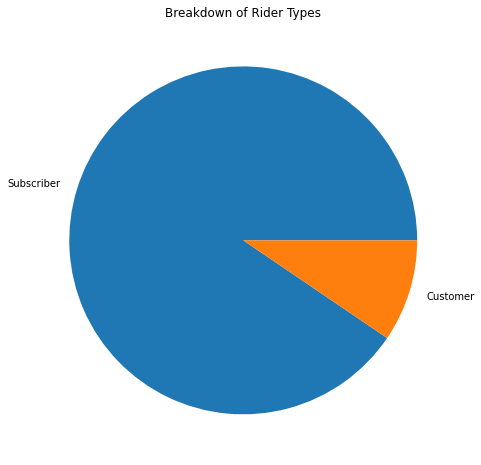

In [51]:
plt.figure(figsize = [10,8])
plt.pie(bikes.user_type.value_counts(), labels = ['Subscriber', 'Customer'])
plt.title('Breakdown of Rider Types');

### Conclusions
The cursorary analysis revealed three aspects of the data:
- Most of the riders from the data set identify as male.
- Most of the riders are after 1980 and a few are set their birth year very low most likely to quickly get through the birth year prompt.
- Most of the riders are Subscribers and not Customers.

## How do Subscribers and Customers rent bikes differently?

Now that we have looked at a basic breakdown into the riders, let's take a look at how the rental styles of the two differ.  Namely, is there a difference on which days and times they start their rentals?

In [37]:
# Add start day as a Categorical column
bikes['start_day'] = bikes.start_time.dt.day_name()
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_cat_type = pd.api.types.CategoricalDtype(categories = day_list, ordered = True)
bikes['start_day'] = bikes.start_day.astype(day_cat_type)

In [38]:
bike_day = bikes.groupby('user_type')['start_day'].value_counts(normalize = True)
bike_day = bike_day.mul(100)
bike_day = bike_day.rename('percent').reset_index()
bike_day.rename(columns = {'level_1': 'start_day'}, inplace = True)

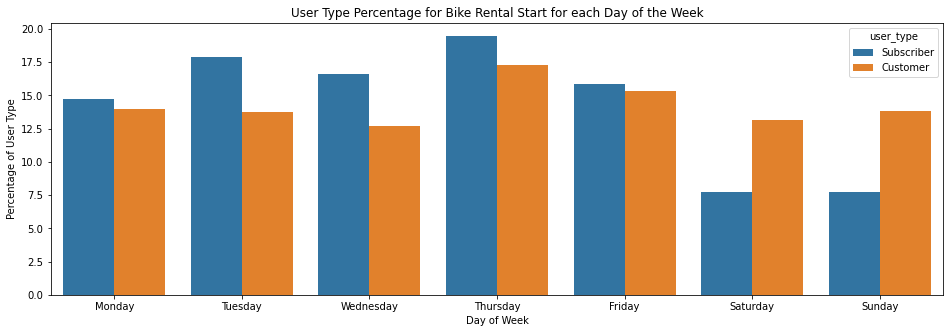

In [45]:
plt.figure(figsize = [16, 5])
sb.barplot(data = bike_day, x = 'start_day', y = 'percent', hue = 'user_type')
plt.title('User Type Percentage for Bike Rental Start for each Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Percentage of User Type');

In [40]:
bikes['start_hour'] = bikes.start_time.dt.hour
bike_hour = bikes.groupby('user_type')['start_hour'].value_counts(normalize = True)
bike_hour = bike_hour.mul(100)
bike_hour = bike_hour.rename('percent').reset_index()

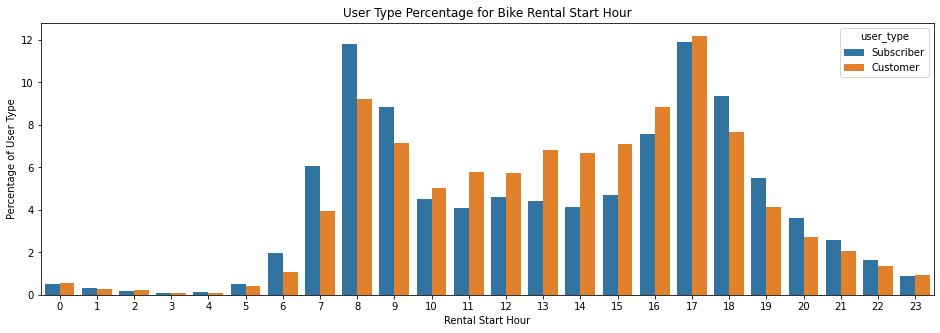

In [46]:
plt.figure(figsize = [16, 5])
sb.barplot( data = bike_hour, x = 'start_hour', y = 'percent', hue = 'user_type')
plt.title('User Type Percentage for Bike Rental Start Hour')
plt.xlabel('Rental Start Hour')
plt.ylabel('Percentage of User Type');

### Conclusions
Now that is certainly interesting!  The percentage breakdown for users at their different start days and hours shows how each group tends to rent bikes.  Namely, we can observe the following:
- Subscribers tend to rent bikes the least on weekends.  It seems like they tend to rent bikes during the work week.  
- Conversely, Customers tend to rent bikes fairly equally throughout the week but mostly weighted around weekends.
- Subscribers definitely have peak times they rent bikes: early in the mornings and late afternoons/early evenings.
- Customers show a similar patterns on rental times.

It seems like Subscribers tend to rent bikes around working hours: during the work week, and right before/after work.  Customers are more likely to rent in the mornings and late afternoons as well but they rent more frequently throughout the day compared to Subscribers.  This may mean that Subscribers are residents or people working in the area while Customers are likely to be people visiting and renting bikes as needed.

## Do Subscribers and Customers ride their bikes different durations?

It was interesting to see when the groups tended to rent their bikes.  If Subscribers are residents, would they rent bikes for shorter duration for a commute?  If Customers are visiting, do they tend to rent bikes for longer as they travel around the city?

Note: for ther est of the analysis, bikes over 4000s (~1.1 hours) were removed as they tended to be outliers in both groups.

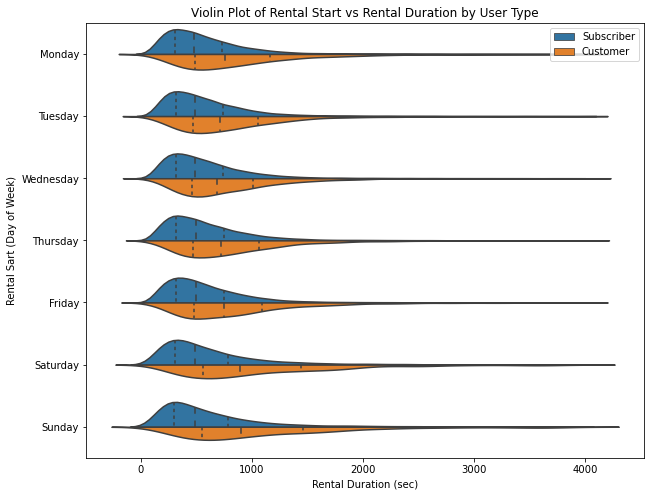

In [52]:
bike_lim_vio = bikes[bikes.duration_sec < 4000].copy()

plt.figure(figsize = [10,8])
sb.violinplot(data = bike_lim_vio, y = 'start_day', x = 'duration_sec',
              hue = 'user_type', split = True, inner = 'quartile', scale = 'area')
plt.xlabel('Rental Duration (sec)')
plt.ylabel('Rental Sart (Day of Week)')
plt.title('Violin Plot of Rental Start vs Rental Duration by User Type')
plt.legend();

In [60]:
start_hours = np.arange(0, 24)
start_hours = start_hours.astype(str)
hour_cat_type = pd.api.types.CategoricalDtype(categories = start_hours, ordered = True)
bike_lim_vio['start_hour'] = bike_lim_vio.start_hour.astype(str)
bike_lim_vio['start_hour'] = bike_lim_vio.start_hour.astype(hour_cat_type)

17    20836
8     20186
18    16084
9     15150
16    13400
7     10205
19     9391
15     8536
12     8133
13     7986
10     7918
14     7579
11     7370
20     6184
21     4374
6      3283
22     2787
23     1558
0       875
5       860
1       519
2       352
4       224
3       157
Name: start_hour, dtype: int64

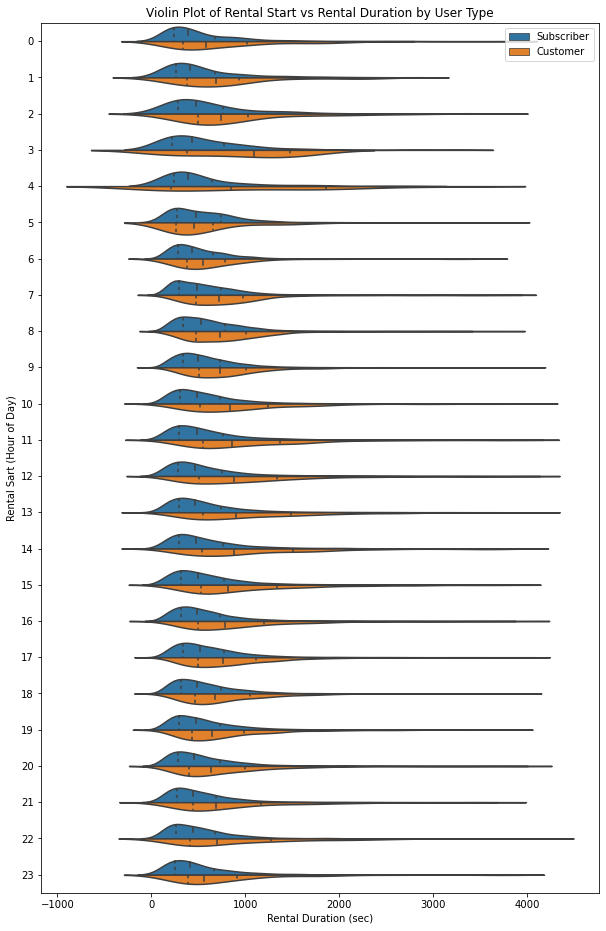

In [61]:
plt.figure(figsize = [10, 16])
sb.violinplot(data = bike_lim_vio, y = 'start_hour', x = 'duration_sec',
              hue = 'user_type', split = True, inner = 'quartile', scale = 'area')
plt.xlabel('Rental Duration (sec)')
plt.ylabel('Rental Sart (Hour of Day)')
plt.title('Violin Plot of Rental Start vs Rental Duration by User Type')
plt.legend();

### Conclusions

Based on the above graphs, Customers tend to rent bikes for a little longer than Subscribers.

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [62]:
!jupyter nbconvert Ford-GoBike-Data-Presentation.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Ford-GoBike-Data-Presentation.ipynb to slides
[NbConvertApp] Writing 856080 bytes to Ford-GoBike-Data-Presentation.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Ford-GoBike-Data-Presentation.slides.html
Use Control-C to stop this server
^C

Interrupted


> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 